In [1]:
# MODIFY! 
# use RobustScaler! 
model_name = 'svr-wo'

# Import Libraries & Data 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('./data/d-wo-ns.csv')
X = df.drop('throughput',axis=1)
y = df['throughput']

---

# Scale Data

In [4]:
# Split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Scale the data
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
scaler.fit(X_train)

RobustScaler()

In [5]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Determine Hyperparameters

In [6]:
# MODIFY!
from sklearn.svm import SVR

model = SVR()
model

SVR()

In [7]:
p_grid = {
    'C':[.001,.01,.1,.5,1],
    'kernel':['linear','rbf','poly'],
    'gamma':['scale','auto'],
    'degree':[2,3,4],
    'epsilon':[0,.01,.1,.5,1,2]
}

In [8]:
from sklearn.model_selection import GridSearchCV

In [9]:
grid_model = GridSearchCV(
    estimator=model,
    param_grid =p_grid, 
    scoring='neg_mean_squared_error',
    cv=3, 
    verbose=1
)

In [10]:
grid_model.fit(X_train,y_train)

Fitting 3 folds for each of 540 candidates, totalling 1620 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1620 out of 1620 | elapsed: 12.9min finished


GridSearchCV(cv=3, estimator=SVR(),
             param_grid={'C': [0.001, 0.01, 0.1, 0.5, 1], 'degree': [2, 3, 4],
                         'epsilon': [0, 0.01, 0.1, 0.5, 1, 2],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf', 'poly']},
             scoring='neg_mean_squared_error', verbose=1)

In [11]:
grid_model.best_params_

{'C': 1, 'degree': 2, 'epsilon': 2, 'gamma': 'scale', 'kernel': 'linear'}

In [12]:
hp = pd.Series(name=f'{model_name} HP', data=grid_model.best_params_)

In [13]:
hp

C               1
degree          2
epsilon         2
gamma       scale
kernel     linear
Name: svr-wo HP, dtype: object

In [14]:
hp.to_csv(f'./hyperparameters/{model_name}.csv')

# Score Model

In [15]:
# MODIFY!
from sklearn.svm import SVR

C_, d_, e_, g_, k_ = grid_model.best_params_.values()

score_model = SVR(
    C = C_,
    degree = d_,
    epsilon = e_, 
    gamma = g_,
    kernel = k_
)

score_model

SVR(C=1, degree=2, epsilon=2, kernel='linear')

In [16]:
from sklearn.model_selection import cross_validate

scores = cross_validate(
    score_model, 
    X_train, 
    y_train,
    scoring=[
        'neg_mean_absolute_error',
        'neg_mean_squared_error',
        'neg_root_mean_squared_error'
    ],
    cv=10
)

In [17]:
scores = pd.DataFrame(scores)

In [18]:
scores

,fit_time,score_time,test_neg_mean_absolute_error,test_neg_mean_squared_error,test_neg_root_mean_squared_error
0,0.375950,0.026882,-4.124434,-26.162055,-5.114886
1,0.582230,0.018644,-5.070542,-39.268688,-6.266473
2,0.331132,0.020233,-4.373545,-30.162016,-5.491996
3,0.324627,0.017994,-4.332661,-28.946368,-5.380183
4,0.344431,0.017974,-4.552237,-33.647940,-5.800684
5,0.404592,0.018444,-4.861516,-38.235797,-6.183510
6,0.304807,0.018878,-4.280127,-29.079211,-5.392514
7,0.285448,0.017846,-4.089870,-26.624698,-5.159913
8,0.325778,0.017830,-4.715310,-33.096742,-5.752977
9,0.343174,0.017990,-4.792369,-34.422800,-5.867095


In [19]:
mean_scores = scores.mean()

In [20]:
mean_scores

fit_time                             0.362217
score_time                           0.019272
test_neg_mean_absolute_error        -4.519261
test_neg_mean_squared_error        -31.964631
test_neg_root_mean_squared_error    -5.641023
dtype: float64

# Export Model Score

In [21]:
mean_scores = mean_scores.rename(f'{model_name}')

In [22]:
mean_scores[[2,3,4]] = mean_scores[[2,3,4]].apply(abs)

In [23]:
# mean_scores

In [24]:
mean_scores = mean_scores.rename({
    'fit_time':'Fit Time',
    'score_time':'Score Time',
    'test_neg_mean_absolute_error':'MAE',
    'test_neg_mean_squared_error':'MSE',
    'test_neg_root_mean_squared_error':'RMSE'
})

In [25]:
mean_scores

Fit Time       0.362217
Score Time     0.019272
MAE            4.519261
MSE           31.964631
RMSE           5.641023
Name: svr-wo, dtype: float64

In [26]:
mean_scores['STD FT'] = scores.fit_time.std()
mean_scores['STD ST'] = scores.score_time.std()
mean_scores['STD MAE'] = scores.test_neg_mean_absolute_error.std()
mean_scores['STD MSE'] = scores.test_neg_mean_squared_error.std()
mean_scores['STD RMSE'] = scores.test_neg_root_mean_squared_error.std()

In [27]:
mean_scores

Fit Time       0.362217
Score Time     0.019272
MAE            4.519261
MSE           31.964631
RMSE           5.641023
STD FT         0.084305
STD ST         0.002772
STD MAE        0.331438
STD MSE        4.542446
STD RMSE       0.399292
Name: svr-wo, dtype: float64

In [28]:
mean_scores.to_csv(f'./scores/{model_name}.csv')

# Holdout Test

In [29]:
score_model.fit(X_train,y_train)

SVR(C=1, degree=2, epsilon=2, kernel='linear')

In [30]:
y_holdout = score_model.predict(X_test)

<AxesSubplot:ylabel='Count'>

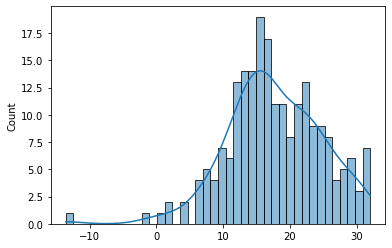

In [31]:
sns.histplot(y_holdout,bins=40,kde=True)

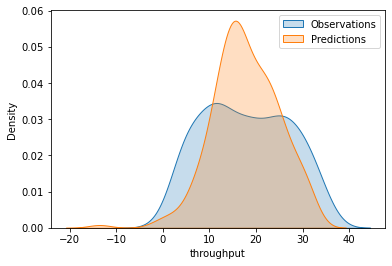

In [32]:
fig,ax = plt.subplots()

sns.kdeplot(y_test, ax=ax, shade=True, label='Observations')
sns.kdeplot(y_holdout, ax=ax,shade=True,label='Predictions')

ax.legend(loc='best')

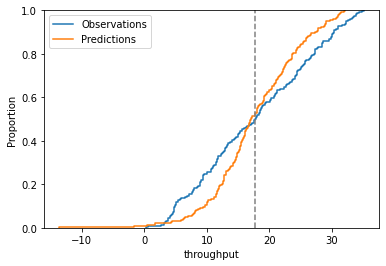

In [33]:
fig,ax = plt.subplots()

sns.ecdfplot(y_test, ax=ax, label='Observations')
sns.ecdfplot(y_holdout, ax=ax,label='Predictions')
plt.axvline(x=y_test.mean(),color='grey',linestyle='--')

ax.legend(loc='best')

In [34]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test,y_holdout)
mse = mean_squared_error(y_test,y_holdout)
rmse = np.sqrt(mse)

In [35]:
err_df = pd.DataFrame(data=[mae, mse, rmse],index=['MAE','MSE','RMSE'],columns=[f'{model_name}'])
err_df

,svr-wo
MAE,4.578561
MSE,33.739938
RMSE,5.808609


In [36]:
err_df.to_csv(f'./holdout-test/{model_name}.csv')
# mean_scores.to_csv(f'./opt-model-err/{model_name}-err.csv')

In [37]:
res = y_test - y_holdout
res.describe().drop('count')

mean     0.003540
std      5.822164
min    -14.518174
25%     -3.479634
50%      0.374641
75%      3.829140
max     14.107434
Name: throughput, dtype: float64

<AxesSubplot:xlabel='throughput', ylabel='Count'>

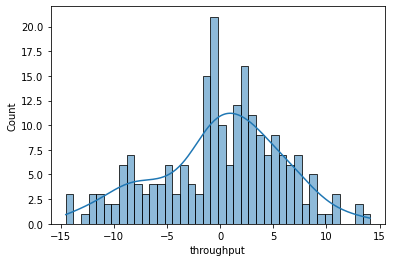

In [38]:
sns.histplot(data=res, kde=True,bins=40)

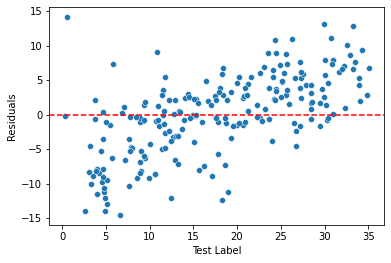

In [39]:
ax = sns.scatterplot(x=y_test, y=res)
ax.set(ylabel='Residuals', xlabel='Test Label')
plt.axhline(y=0,color='red',linestyle='--')

# there should be no clear pattern / curve in the plot
# we see a positive correlation between Test Label and Residuals -> later models should avoid this pattern

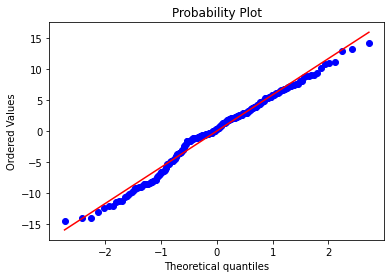

In [40]:
import scipy as sp

fig, ax = plt.subplots()
sp.stats.probplot(res,plot=ax);

# Export Optimized Model

In [41]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
scaler.fit(X)

RobustScaler()

In [42]:
# MODIFY! 
X = scaler.transform(X)

op_model = score_model

op_model.fit(X,y)

SVR(C=1, degree=2, epsilon=2, kernel='linear')

In [43]:
y_pred = op_model.predict(X)

<AxesSubplot:ylabel='Count'>

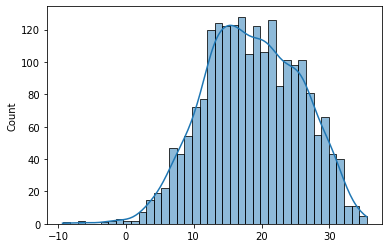

In [44]:
sns.histplot(y_pred,bins=40,kde=True)

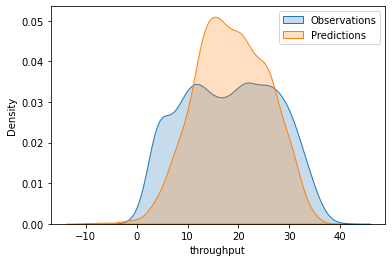

In [45]:
fig,ax = plt.subplots()

sns.kdeplot(y, ax=ax, shade=True, label='Observations')
sns.kdeplot(y_pred, ax=ax,shade=True,label='Predictions')

ax.legend(loc='best')

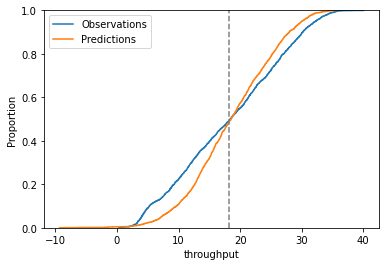

In [46]:
fig,ax = plt.subplots()

sns.ecdfplot(y, ax=ax, label='Observations')
sns.ecdfplot(y_pred, ax=ax,label='Predictions')
plt.axvline(x=y.mean(),color='grey',linestyle='--')

ax.legend(loc='best')

In [47]:
mae = mean_absolute_error(y,y_pred)
mse = mean_squared_error(y,y_pred)
rmse = np.sqrt(mse)

In [48]:
err_df = pd.DataFrame(data=[mae, mse, rmse],index=['MAE','MSE','RMSE'],columns=[f'{model_name}'])
err_df

,svr-wo
MAE,4.349319
MSE,29.888499
RMSE,5.467038


In [49]:
err_df.to_csv(f'./model-err/{model_name}.csv')
# mean_scores.to_csv(f'./opt-model-err/{model_name}-err.csv')

In [50]:
from joblib import dump, load
dump(op_model, f'./opt-models/{model_name}.joblib')

['./opt-models/svr-wo.joblib']

In [51]:
res = y - y_pred
res.describe().drop('count')

mean    -0.451658
std      5.449621
min    -23.613383
25%     -3.905522
50%      0.099857
75%      3.302456
max     15.853785
Name: throughput, dtype: float64

<AxesSubplot:xlabel='throughput', ylabel='Count'>

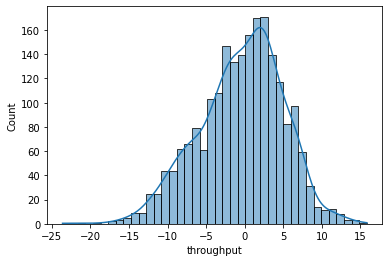

In [52]:
sns.histplot(data=res, kde=True,bins=40)

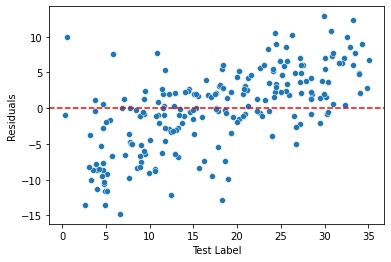

In [53]:
ax = sns.scatterplot(x=y_test, y=res)
ax.set(ylabel='Residuals', xlabel='Test Label')
plt.axhline(y=0,color='red',linestyle='--')

# there should be no clear pattern / curve in the plot
# we see a positive correlation between Test Label and Residuals -> later models should avoid this pattern

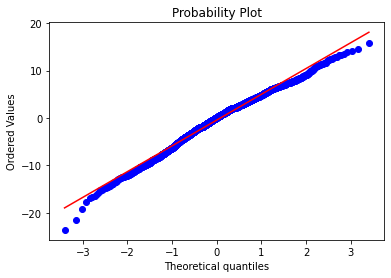

In [54]:
import scipy as sp

fig, ax = plt.subplots()
sp.stats.probplot(res,plot=ax);

DONE!